# DS Hackathon
## Image Segmentation
#### Team A
Challenge Description:
Your team must design a segmentation model which detects miscellaneous defects, learns from a weakly
labeled dataset, and works on images whose characteristics are unknown at development time.
Detecting defects in the industry is one of the most important tasks in visual inspection and it is still an
active topic in computer vision applications research. The dataset and problem presented here are a good
introduction to get an idea of the type of challenges that are faced in Automatic visual defect detection in
the industry.
The dataset in this challenge consists of different anomalies or indications in a variety of background
textures. The dataset is synthetic, but it is based on real indications, it was originally created for a
competition at the 2007 symposium of the DAGM, and it is publicly available from the University of
Heidelberg website.
Be aware that we have slightly modified the images for this challenge, and that they are the only ones that
you should use as input. However, techniques as data augmentation are encouraged.

[Kaggle Competition Link](https://www.kaggle.com/t/da322bd83be74d8e8fa27dd16d8956c0)

This notebook is based on the Simple Cell Segmentation with Keras and U-Net notebook on kagle created by Marsh
https://www.kaggle.com/vbookshelf/simple-cell-segmentation-with-keras-and-u-net

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure images dimensions
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

NUM_TEST_IMAGES = 10

## Get Data

In [3]:
# get our data 

img_list = os.listdir('D:/Augmentation/Image')
mask_list = os.listdir('D:/Augmentation/Mask')

# create a dataframe
df_images = pd.DataFrame(img_list, columns=['image_id'])

# filter out the non image file that's called .htaccess
df_images = df_images[df_images['image_id'] != '.htaccess']

# Keep in mind images and masks have the same file names.

def check_for_mask(x):
    if x in mask_list:
        return 'yes'
    else:
        return 'no'
    
# create a new column called 'has_mask'
df_images['has_mask'] = df_images['image_id'].apply(check_for_mask)



In [4]:
df_images.head(10)

,image_id,has_mask
0,0001.png,yes
1,0002.png,yes
2,0003.png,yes
3,0004.png,yes
4,0005.png,yes
5,0006.png,yes
6,0007.png,yes
7,0008.png,yes
8,0009.png,yes
9,0010.png,yes


In [5]:
df_masks = df_images[df_images['has_mask'] == 'yes']

# create a new column called mask_id that is just a copy of image_id
df_masks['mask_id'] = df_masks['image_id']

df_masks.shape

(2450, 3)

## Split Dataset

In [6]:
# create a test set
df_test = df_masks.sample(NUM_TEST_IMAGES, random_state=101)

# Reset the index.
# This is so that we can use loc to access mask id's later.
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])


# Select only rows that are not part of the test set.
# Note the use of ~ to execute 'not in'.
df_masks = df_masks[~df_masks['image_id'].isin(test_images_list)]

print(df_masks.shape)
print(df_test.shape)

(2440, 3)
(10, 3)


In [7]:
# Get lists of images and their masks.
image_id_list = list(df_masks['image_id'])
mask_id_list = list(df_masks['mask_id'])
test_id_list = list(df_test['image_id'])

# Create empty arrays

X_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

Y_train = np.zeros((len(image_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((NUM_TEST_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [8]:
# X_train
for i, image_id in enumerate(image_id_list):
    
    path_image = 'D:/Augmentation/Image/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_train
    X_train[i] = image
    
X_train.shape

(2440, 128, 128, 1)

In [9]:
# Y_train
for i, mask_id in enumerate(mask_id_list):
    
    path_mask = 'D:/Augmentation/Mask/' + mask_id
    
    # read the image using skimage
    mask = imread(path_mask)
    
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

(2440, 128, 128, 1)

In [10]:
# X_test

for i, image_id in enumerate(test_id_list):
    
    path_image = 'D:/Augmentation/Image/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    image = np.expand_dims(image, axis=-1)
    
    # insert the image into X_test
    X_test[i] = image
    
X_test.shape

(10, 128, 128, 1)

## Architecture U-net


In [11]:
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

import tensorflow as tf

In [12]:
# source: https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Train

In [13]:
# path to save model
filepath = "model.h5"

# Training parameters 
earlystopper = EarlyStopping(patience=10, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=120, 
                    callbacks=callbacks_list)

Epoch 1/110
138/138 [==============================] - 15s 61ms/step - loss: 0.1814 - val_loss: 0.1260

Epoch 00001: val_loss improved from inf to 0.12602, saving model to model.h5
Epoch 2/110
138/138 [==============================] - 6s 47ms/step - loss: 0.0897 - val_loss: 0.1157

Epoch 00002: val_loss improved from 0.12602 to 0.11572, saving model to model.h5
Epoch 3/110
138/138 [==============================] - 6s 47ms/step - loss: 0.0681 - val_loss: 0.1054

Epoch 00003: val_loss improved from 0.11572 to 0.10544, saving model to model.h5
Epoch 4/110
138/138 [==============================] - 7s 47ms/step - loss: 0.0699 - val_loss: 0.1062

Epoch 00004: val_loss did not improve from 0.10544
Epoch 5/110
138/138 [==============================] - 7s 47ms/step - loss: 0.0581 - val_loss: 0.1036

Epoch 00005: val_loss improved from 0.10544 to 0.10365, saving model to model.h5
Epoch 6/110
138/138 [==============================] - 7s 47ms/step - loss: 0.0625 - val_loss: 0.1033

Epoch 0000

## Make Predictions

In [14]:
# Load model
model.load_weights('model.h5')

test_preds = model.predict(X_test)

In [15]:
# Threshold the predictions

preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)

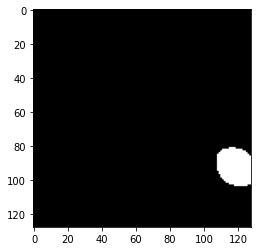

In [16]:
# Display a thresholded mask
test_img = preds_test_thresh[3, :, :, 0]

plt.imshow(test_img, cmap='gray')

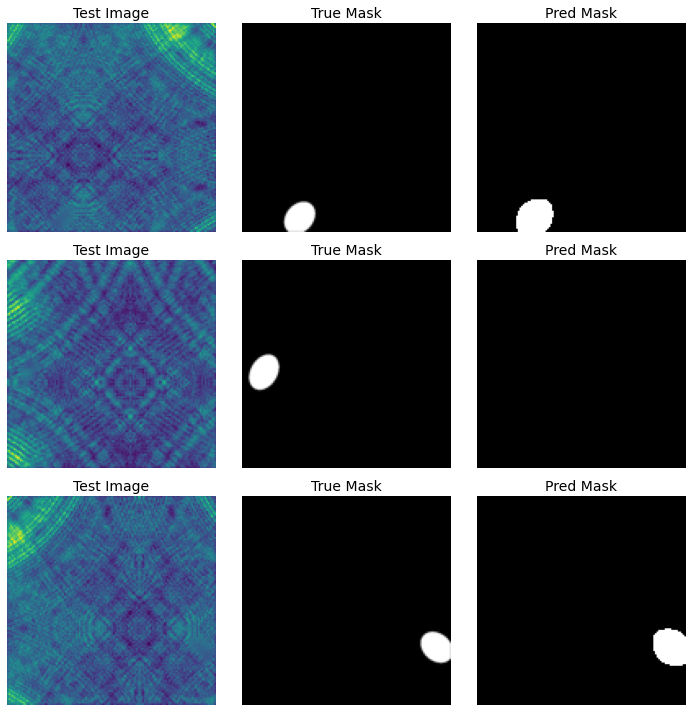

In [17]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = X_test[1, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask_id = df_test.loc[1,'mask_id']
path_mask = 'D:/Augmentation/Mask/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = preds_test_thresh[1, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = X_test[2, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask_id = df_test.loc[2,'mask_id']
path_mask = 'D:/Augmentation/Mask/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = preds_test_thresh[2, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = X_test[8, :, :, 0]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask_id = df_test.loc[8,'mask_id']
path_mask = 'D:/Augmentation/Mask/' + mask_id
mask = imread(path_mask)
mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = preds_test_thresh[8, :, :, 0]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()

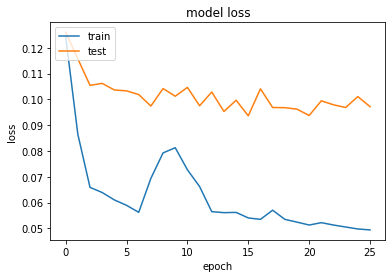

In [18]:
# summarize history for loss

history.history.keys()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# m = tf.keras.metrics.MeanIoU(num_classes=3)
# m.update_state(model.predict(X_train), Y_train)
# m.result().numpy()

## Predict on unseen data

In [20]:
# import packages
import cv2
import json
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [21]:
X_val = np.zeros((len(os.listdir('Test/Image')), IMG_HEIGHT, IMG_WIDTH,1), dtype=np.uint8)

for i, image_id in enumerate(os.listdir('Test/Image')):
    
    path_image = 'Test/Image/' + image_id
    
    # read the image using skimage
    image = imread(path_image)
    
    # resize the image
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    
    
    # add image to X_val
    X_val[i] = image
    
X_val.shape

(400, 128, 128, 1)

In [22]:
val_preds = model.predict(X_val)

In [23]:
preds_val_thresh = (val_preds >= 0.5).astype(np.uint8)

## Run length encoding

In [24]:
# Function retrieve from https://www.kaggle.com/leahscherschel/run-length-encoding
# Modified to return data as string 

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), non 0 - mask, 0 - background
    Returns run length as string
    '''
    run_lengths = []
    for i in range(len(x)):
        run_lengths.append([])
    current = 0
    count = 0
    start = 0
    flat = x.T.flatten()
    for i in range(len(flat)):
        dot = flat[i]
        if dot == 0:
            if current == 0:
                continue
            else:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
        else:
            if dot == current:
                count += 1
            elif count != 0:
                run_lengths[current-1].extend([start, count])
                current = 0
                count = 0
                start = 0
            else:
                start = i
                current = dot
                count += 1
    return ' '.join(str(x) for x in run_lengths[0])


In [ ]:
# Save in a CSV images numbers and RLE encoded values
with open('test.csv', 'w', encoding='UTF8', newline='') as f:
    header = ['ImageId', 'EncodedPixels']
    writer = csv.writer(f)
    writer.writerow(header)

    for i, j in enumerate(os.listdir('Test/Image')):
        print(i)
        img = np.array(preds_val_thresh[i,:,:,0])
        img = resize(img, (512, 512), mode='constant', preserve_range=True)
        rle_encoded = rle_encoding(img.astype('uint16'))

        data = [j[:-4], rle_encoded]

        writer.writerow(data)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
